In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import peakutils
import matplotlib.pyplot as plt
import scipy.signal as sg
from scipy.signal import welch, butter, freqz, lfilter
import sys
from numpy import NaN, Inf, arange, isscalar, asarray, array, isnan, argwhere, argmax, argmin, fft, absolute
from statistics import mean, stdev, variance
from scipy.stats import kurtosis, skew
from sklearn import neighbors, preprocessing, svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from pyentrp import entropy as ent
import operator

%matplotlib inline

In [2]:
subject_file_names = ["ID001","ID002","ID003","ID004","ID005",
                     "ID006","ID007","ID008","ID009","ID010",
                     "ID011","ID012","ID013","ID014","ID015",
                    "ID016","ID017","ID018","ID019","ID020"]

label_map = {"ID001": 1,"ID002": 2,"ID003": 3,"ID004": 4,"ID005": 5,
            "ID006": 6,"ID007":7,"ID008":8,"ID009":9,"ID010":10,
            "ID011":11,"ID012":12,"ID013":13,"ID014":14,"ID015":15,
            "ID016":16,"ID017":17,"ID018":18,"ID019":19,"ID020":20}

label_dict = {1:"ID001",2:"ID002",3:"ID003",4:"ID004",5:"ID005",
             6:"ID006",7:"ID007",8:"ID008",9:"ID009",10:"ID010",
             11:"ID011",12:"ID012",13:"ID013",14:"ID014",15:"ID015",
            16:"ID016",17:"ID017",18:"ID018",19:"ID019",20:"ID020"}

threshold = []
threshold_value = 0
while threshold_value <= 100:
    threshold.append(threshold_value)
    threshold_value += 5
print(threshold)

[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]


In [3]:
acc_f = open("Results/accelerometer_enrollment.csv","w+")
gyr_f = open("Results/gyroscope_enrollment.csv","w+")

In [4]:
class Feature_Vector: 
    def __init__(self, max_amplitude, min_amplitude, mean, variance,  kurtosis,
        skewness, ptp_time, alar, energy, entropy_1, entropy_2, entropy_3, entropy_4, 
                 entropy_5, entropy_6, entropy_7, entropy_8):
        self.max_amplitude = max_amplitude
        self.min_amplitude = min_amplitude
        self.mean = mean
        self.variance = variance
        self.kurtosis = kurtosis
        self.skewness = skewness
        self.ptp_time = ptp_time
        self.alar = alar
        self.energy = energy
        self.entropy_1 = entropy_1
        self.entropy_2 = entropy_2
        self.entropy_3 = entropy_3
        self.entropy_4 = entropy_4
        self.entropy_5 = entropy_5
        self.entropy_6 = entropy_6
        self.entropy_7 = entropy_7
        self.entropy_8 = entropy_8
        
    def toCSV(self):
        return(','.join([str(i) for i in [self.max_amplitude,self.min_amplitude,self.mean,
                                    self.variance,self.kurtosis,self.skewness,
                                    self.ptp_time,self.alar,self.energy, 
                                      self.entropy_1, self.entropy_2, self.entropy_3, self.entropy_4,
                                         self.entropy_5, self.entropy_6, self.entropy_7, self.entropy_8]]))

In [5]:
def signal_preprocessing(filename, sfn, command, feature_vector_list=None):
    list = []
    
    df_gait_file = pd.read_csv(filename, index_col="time").iloc[100:-100]
    df_gait_file.index *= 0.001

    #calculate magnitude
    df_gait_file["magnitude"] = np.sqrt(np.square(df_gait_file).sum(axis=1))
    
    #Interpolate the data using a cubic spline
    df_gait_file_spline = df_gait_file.reindex(np.arange(df_gait_file.index[0], df_gait_file.index[-1], 0.005), method="nearest", tolerance=0.002)
    df_gait_file_spline = df_gait_file_spline.interpolate(method="cubic").dropna()
    
    #Buterworth filter 
    def butter_lowpass(cutoff, fs, order=5):
        nyq = 0.5 * fs
        normal_cutoff = cutoff / nyq
        b, a = butter(order, normal_cutoff, btype='low', analog=False)
        return b, a

    def butter_lowpass_filter(data, cutoff, fs, order=5):
        b, a = butter_lowpass(cutoff, fs, order=order)
        y = lfilter(b, a, data)
        return y

    # Filter requirements.
    order = 5
    fs = 200.0       # sample rate, Hz
    cutoff = 3  # desired cutoff frequency of the filter, Hz

    # Get the filter coefficients so we can check its frequency response.
    b, a = butter_lowpass(cutoff, fs, order)
    
    df_gait_file_spline["filtered"] = butter_lowpass_filter(df_gait_file_spline["magnitude"], cutoff, fs, order)
    filtered = butter_lowpass_filter(df_gait_file_spline["magnitude"], cutoff, fs, order)

    col1 = df_gait_file_spline.index # First column data
    col2 = array(df_gait_file_spline["filtered"]) # Second column data
    
    #Optimal Threshold filter
    def find_optimal_threshold(t_low=0.2, t_high=1.0):
        """
        Finds the threshold as the one which minimises the standard deviation of the difference between peaks
        (normalised to the smallest value). 
        """
        optimal_threshold = 0.65
        closest_stdev = 10000.0
        for threshold in arange(t_low, t_high, 0.01):
            index = peakutils.indexes(-col2, thres=threshold, min_dist=20)
            index_diff = [index[i+1] - index[i] for i in range(len(index) - 1)]
            index_diff_norm = [float(idx)/min(index_diff) for idx in index_diff]
            if len(index_diff_norm) < 5:
                continue
            test_stdev = stdev(index_diff_norm)
            if test_stdev < closest_stdev:
                closest_stdev = test_stdev
                optimal_threshold = threshold
        return optimal_threshold
   
    thres = find_optimal_threshold()
    #print ("Optimal threshold = %s" % thres)
    index = peakutils.indexes(-col2, thres=thres, min_dist=80)
    #print('Peaks are: %s' % (index))
    
    index_diff = [index[i+1] - index[i] for i in range(len(index) - 1)]
    seg_mean, seg_stdev = mean(index_diff), stdev(index_diff)
    #print (seg_mean, seg_stdev)

    traces = []
    for i in range(len(index) - 1):
        if abs(index_diff[i] - seg_mean) > seg_stdev:
            continue
        traces.append(array(df_gait_file_spline["filtered"].iloc[index[i]:index[i+1]]))
        
    longest_trace_length = max([len(t) for t in traces])

    average_trace = []
    stdev_trace = []

    for i in range(longest_trace_length):
        vals = []
        for t in traces:
            try:
                vals.append(t[i])
            except IndexError:
                pass
        average_trace.append(mean(vals))
        try:
            stdev_trace.append(stdev(vals))
        except:
            stdev_trace.append(0.0)

    average_trace = array(average_trace)
    stdev_trace = array(stdev_trace)

    #Print features for all traces     
    if command == "append to accelerometer training file":
        for t in traces:
            std_t = np.std(t)
            A_k = fft.fft(t, 64)
            entropy = ent.sample_entropy(t, 8, 0.2 * std_t)    
            data =(','.join([str(i) for i in [max(t), min(t), mean(t), variance(t), kurtosis(t),
                                                  skew(t), argmax(t)*0.005 + argmin(t)*0.005, 
                                                 argmax(t)*0.005/max(t), sum(absolute(A_k)**2)/len(A_k),
                                                 entropy[0], entropy[1], entropy[2], entropy[3],
                                             entropy[4], entropy[5], entropy[6], entropy[7]]]))
            with open("Results/accelerometer_enrollment.csv","a+") as acc_f:
                    acc_f.write(data + "," + sfn + "\n")
                    acc_f.close()
    if command == "append to gyroscope training file":
        for t in traces:
            std_t = np.std(t)
            A_k = fft.fft(t, 64)
            entropy = ent.sample_entropy(t, 8, 0.2 * std_t)
            data =(','.join([str(i) for i in [max(t), min(t), mean(t), variance(t), kurtosis(t),
                                                  skew(t), argmax(t)*0.005 + argmin(t)*0.005, 
                                                 argmax(t)*0.005/max(t), sum(absolute(A_k)**2)/len(A_k),
                                                entropy[0], entropy[1], entropy[2], entropy[3],
                                             entropy[4], entropy[5], entropy[6], entropy[7]]]))
            with open("Results/gyroscope_enrollment.csv","a+") as gyr_f:
                gyr_f.write(data + "," + sfn + "\n")
                gyr_f.close()
                
    if command == "populate accelerometer fv list":
        for t in traces:
            std_t = np.std(t)
            A_k = fft.fft(t, 64)
            entropy = ent.sample_entropy(t, 8, 0.2 * std_t)
            feature_vector_list.append(Feature_Vector(max(t), min(t), 
                                                      mean(t), variance(t), kurtosis(t), skew(t), 
                                                      argmax(t)*0.005 + argmin(t)*0.005, argmax(t)*0.005/max(t), 
                                                      sum(absolute(A_k)**2)/len(A_k), 
                                                      entropy[0], entropy[1], entropy[2], entropy[3],
                                                     entropy[4], entropy[5], entropy[6], entropy[7]))
        
    if command == "populate gyroscope fv list":
        for t in traces:
            std_t = np.std(t)
            A_k = fft.fft(t, 64)
            entropy = ent.sample_entropy(t, 8, 0.2 * std_t)
            feature_vector_list.append(
                Feature_Vector(max(t), min(t), mean(t), variance(t),
                               kurtosis(t), skew(t), argmax(t)*0.005 + argmin(t)*0.005, 
                               argmax(t)*0.005/max(t), sum(absolute(A_k)**2)/len(A_k),
                              entropy[0], entropy[1], entropy[2], entropy[3],
                              entropy[4], entropy[5], entropy[6], entropy[7]))

In [6]:
#Enrollment process

for sfn in subject_file_names:
    print("PROCESSING " + sfn)
    signal_preprocessing("UJGaitDataset/accTrain/" + sfn + "-accelerometer01.csv", sfn, "append to accelerometer training file")
    signal_preprocessing("UJGaitDataset/gyrTrain/" + sfn + "-gyroscope01.csv", sfn, "append to gyroscope training file")


PROCESSING ID001
PROCESSING ID002
PROCESSING ID003
PROCESSING ID004
PROCESSING ID005
PROCESSING ID006
PROCESSING ID007
PROCESSING ID008
PROCESSING ID009
PROCESSING ID010
PROCESSING ID011
PROCESSING ID012
PROCESSING ID013
PROCESSING ID014
PROCESSING ID015
PROCESSING ID016
PROCESSING ID017
PROCESSING ID018
PROCESSING ID019
PROCESSING ID020


In [7]:
def classification_task(sensor, preprocessed_sample, list_for_results):
    
    classification_data = pd.read_csv("Results/" + sensor + "_enrollment.csv", 
                                      names=["a_max_amplitude", "a_min_amplitude", "a_mean",
                                              "a_variance","a_kurtosis","a_skewness","a_pp_time",
                                              "a_alar", "a_energy","a_entropy_1", "a_entropy_2", 
                                             "a_entropy_3", "a_entropy_4","a_entropy_5", "a_entropy_6", 
                                             "a_entropy_7", "a_entropy_8","label",])
    classification_data["logical_label"] = classification_data["label"].dropna().apply(lambda x: label_map[x])
    X = np.transpose(np.vstack((np.array(classification_data["a_max_amplitude"]), np.array(classification_data["a_min_amplitude"]),
                            np.array(classification_data["a_mean"]), np.array(classification_data["a_variance"]),
                           np.array(classification_data["a_kurtosis"]), np.array(classification_data["a_skewness"]),
                           np.array(classification_data["a_pp_time"]), np.array(classification_data["a_alar"]),
                           np.array(classification_data["a_energy"]), np.array(classification_data["a_entropy_1"]),
                               np.array(classification_data["a_entropy_2"]), np.array(classification_data["a_entropy_3"]),
                               np.array(classification_data["a_entropy_4"]), np.array(classification_data["a_entropy_5"]),
                               np.array(classification_data["a_entropy_6"]), np.array(classification_data["a_entropy_7"]),
                               np.array(classification_data["a_entropy_8"]))))

    X_scaled = preprocessing.scale(X)
    means = X.mean(axis=0)
    stdevs = X.std(axis=0)
    y = np.hstack(np.array(classification_data["logical_label"]))
    means, stdevs

    #knn=neighbors.KNeighborsClassifier()
    #knn.fit(X_scaled, Y)
    
    clf = svm.SVC()
    clf.fit(X_scaled, y)
    
    test = preprocessed_sample
    test_array = test.split(",")
    test_array = list(map(float, test_array))
    scaled_test_array = (test_array - means)/stdevs
    #print(knn.predict([scaled_test_array])[0])
    #list_for_results.append(knn.predict([scaled_test_array])[0])
    list_for_results.append(clf.predict([scaled_test_array])[0])


In [8]:
def classify(sfn, acc_score_list, gyr_score_list):
    acc_feature_vector_list = []
    gyr_feature_vector_list = []
    
    signal_preprocessing("UJGaitDataset/accTest/" + sfn + "-accelerometer02.csv", sfn, "populate accelerometer fv list", acc_feature_vector_list)
    signal_preprocessing("UJGaitDataset/gyrTest/" + sfn + "-gyroscope02.csv", sfn, "populate gyroscope fv list", gyr_feature_vector_list)
    
    for a in range(len(acc_feature_vector_list) - 1):
        classification_task("accelerometer", acc_feature_vector_list[a].toCSV(), acc_score_list)
    for g in range(len(gyr_feature_vector_list) - 1):
        classification_task("gyroscope", gyr_feature_vector_list[g].toCSV(), gyr_score_list)
    


In [9]:
def results(sfn, acc_score_list, gyr_score_list, tpr, fpr, pass_percentage, threshold_index):
    
    authenticated = False
    valid_access_control_decision = False
    weighted_percentage = 0.0
    
    print("\nACCELEROMETER CLASSIFICATION RESULTS")

    a_dict = {}
    for a in acc_score_list:
        if label_dict[a] in a_dict:
            a_dict[label_dict[a]] += 1
        else:
            a_dict[label_dict[a]] = 1
    print(a_dict)
    for key, value in a_dict.items():
        print(str(round(value*100/len(acc_score_list),1)) + "% - " + key)
    
    print("\nGYROSCOPE CLASSIFICATION RESULTS")
    g_dict = {}
    for g in gyr_score_list:
        if label_dict[g] in g_dict:
            g_dict[label_dict[g]] += 1
        else:
            g_dict[label_dict[g]] = 1
    print(g_dict)        
    for key, value in g_dict.items():
        print(str(round(value*100/len(gyr_score_list),1)) + "% - " + key)
        
    a_max = max(a_dict.items(), key=operator.itemgetter(1))[0]
    g_max = max(g_dict.items(), key=operator.itemgetter(1))[0]
    
    #print("\n")
    #print("a max: " + a_max + " g max: " + g_max)
    
    if a_max == g_max:
        weighted_percentage = (5.5 * ((a_dict[a_max] * 100)/len(acc_score_list)) + 4.5 * ((g_dict[g_max] * 100)/len(gyr_score_list)))/10
        print("weighted_percentage: " + str(round(weighted_percentage,2)) + "%")
        if weighted_percentage >= pass_percentage:
            authenticated = True
    else:
        weighted_percentage = (a_dict[a_max]*100/len(acc_score_list))
        print("weighted_percentage: " + str(round(weighted_percentage,2)) + "%")

        if weighted_percentage > 80 or weighted_percentage >= pass_percentage + 15:
            authenticated = True

    print("\n")        
    print(a_max + " authentication status: " + str(authenticated))
    
    if sfn == a_max:
        valid_access_control_decision = True
    
    print("Valid access control: " + str(valid_access_control_decision))
  
    #FAR++
    if authenticated is True and valid_access_control_decision is False:
        fpr[c] += 1       
    if authenticated is True and valid_access_control_decision is True:
        tpr[c] += 1        

    print(fpr)  
    print(tpr)

In [10]:
tpr = np.zeros(len(threshold))
fpr = np.zeros(len(threshold))

roc_auc = dict()

for c in range(len(threshold) - 1):
    print("******************************************* Threshold: " + str(threshold[c]) + "% *************************************")
    for sfn in subject_file_names:
        acc_score_list = []
        gyr_score_list = []
        
        print("\n" + sfn + " - Classification")
        classify(sfn, acc_score_list, gyr_score_list)
        results(sfn, acc_score_list, gyr_score_list, tpr, fpr, threshold[c], c)

******************************************* Threshold: 0% *************************************

ID001 - Classification

ACCELEROMETER CLASSIFICATION RESULTS
{'ID005': 1, 'ID015': 1, 'ID004': 2}
25.0% - ID005
25.0% - ID015
50.0% - ID004

GYROSCOPE CLASSIFICATION RESULTS
{'ID017': 2, 'ID005': 1, 'ID004': 4, 'ID001': 14, 'ID014': 1}
9.1% - ID017
4.5% - ID005
18.2% - ID004
63.6% - ID001
4.5% - ID014
weighted_percentage: 50.0%


ID004 authentication status: True
Valid access control: False
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

ID002 - Classification

ACCELEROMETER CLASSIFICATION RESULTS
{'ID002': 22, 'ID009': 1}
95.7% - ID002
4.3% - ID009

GYROSCOPE CLASSIFICATION RESULTS
{'ID018': 6, 'ID006': 3, 'ID020': 2}
54.5% - ID018
27.3% - ID006
18.2% - ID020
weighted_percentage: 95.65%


ID002 authentication status: True
Valid access control: True
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.


ACCELEROMETER CLASSIFICATION RESULTS
{'ID017': 16, 'ID014': 14, 'ID009': 1}
51.6% - ID017
45.2% - ID014
3.2% - ID009

GYROSCOPE CLASSIFICATION RESULTS
{'ID018': 2, 'ID004': 10, 'ID017': 16}
7.1% - ID018
35.7% - ID004
57.1% - ID017
weighted_percentage: 54.1%


ID017 authentication status: True
Valid access control: True
[4. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[13.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.]

ID018 - Classification

ACCELEROMETER CLASSIFICATION RESULTS
{'ID018': 8, 'ID013': 2, 'ID008': 1, 'ID003': 2}
61.5% - ID018
15.4% - ID013
7.7% - ID008
15.4% - ID003

GYROSCOPE CLASSIFICATION RESULTS
{'ID018': 5, 'ID016': 9, 'ID002': 6, 'ID012': 2, 'ID007': 6, 'ID005': 4, 'ID003': 1, 'ID015': 1}
14.7% - ID018
26.5% - ID016
17.6% - ID002
5.9% - ID012
17.6% - ID007
11.8% - ID005
2.9% - ID003
2.9% - ID015
weighted_percentage: 61.54%


ID018 authentication status: True
Valid access control: True
[4. 0. 0. 0. 0. 0. 0. 0. 0. 0


ACCELEROMETER CLASSIFICATION RESULTS
{'ID013': 19}
100.0% - ID013

GYROSCOPE CLASSIFICATION RESULTS
{'ID013': 16}
100.0% - ID013
weighted_percentage: 100.0%


ID013 authentication status: True
Valid access control: True
[5. 3. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[15. 10.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.]

ID014 - Classification

ACCELEROMETER CLASSIFICATION RESULTS
{'ID014': 18, 'ID004': 4, 'ID002': 1, 'ID017': 2}
72.0% - ID014
16.0% - ID004
4.0% - ID002
8.0% - ID017

GYROSCOPE CLASSIFICATION RESULTS
{'ID014': 20, 'ID004': 4, 'ID017': 5, 'ID005': 1}
66.7% - ID014
13.3% - ID004
16.7% - ID017
3.3% - ID005
weighted_percentage: 69.6%


ID014 authentication status: True
Valid access control: True
[5. 3. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[15. 11.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.]

ID015 - Classification

ACCELEROMETER CLASSIFICATION RESULTS
{'ID015': 5, 'ID00


ACCELEROMETER CLASSIFICATION RESULTS
{'ID009': 35}
100.0% - ID009

GYROSCOPE CLASSIFICATION RESULTS
{'ID013': 1, 'ID019': 4, 'ID008': 1, 'ID018': 2, 'ID005': 4, 'ID012': 2}
7.1% - ID013
28.6% - ID019
7.1% - ID008
14.3% - ID018
28.6% - ID005
14.3% - ID012
weighted_percentage: 100.0%


ID009 authentication status: True
Valid access control: True
[5. 5. 3. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[15. 15.  6.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.]

ID010 - Classification

ACCELEROMETER CLASSIFICATION RESULTS
{'ID010': 13, 'ID020': 1, 'ID015': 1, 'ID018': 3}
72.2% - ID010
5.6% - ID020
5.6% - ID015
16.7% - ID018

GYROSCOPE CLASSIFICATION RESULTS
{'ID010': 11, 'ID020': 1, 'ID018': 2, 'ID013': 1}
73.3% - ID010
6.7% - ID020
13.3% - ID018
6.7% - ID013
weighted_percentage: 72.72%


ID010 authentication status: True
Valid access control: True
[5. 5. 3. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[15. 15.  7.  0.  0.  0.  0.  0.  0.  0. 


ACCELEROMETER CLASSIFICATION RESULTS
{'ID005': 4, 'ID009': 2}
66.7% - ID005
33.3% - ID009

GYROSCOPE CLASSIFICATION RESULTS
{'ID001': 6, 'ID004': 3, 'ID002': 1}
60.0% - ID001
30.0% - ID004
10.0% - ID002
weighted_percentage: 66.67%


ID005 authentication status: True
Valid access control: True
[5. 5. 5. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[15. 15. 15.  3.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.]

ID006 - Classification

ACCELEROMETER CLASSIFICATION RESULTS
{'ID013': 3, 'ID016': 1}
75.0% - ID013
25.0% - ID016

GYROSCOPE CLASSIFICATION RESULTS
{'ID007': 2, 'ID019': 2, 'ID011': 2, 'ID016': 2, 'ID005': 1}
22.2% - ID007
22.2% - ID019
22.2% - ID011
22.2% - ID016
11.1% - ID005
weighted_percentage: 75.0%


ID013 authentication status: True
Valid access control: False
[5. 5. 5. 3. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[15. 15. 15.  3.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.]

ID007 - Classification

ACCEL


ACCELEROMETER CLASSIFICATION RESULTS
{'ID020': 12}
100.0% - ID020

GYROSCOPE CLASSIFICATION RESULTS
{'ID020': 9, 'ID010': 1}
90.0% - ID020
10.0% - ID010
weighted_percentage: 95.5%


ID020 authentication status: True
Valid access control: True
[5. 5. 5. 4. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[15. 15. 15. 15.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.]
******************************************* Threshold: 20% *************************************

ID001 - Classification

ACCELEROMETER CLASSIFICATION RESULTS
{'ID005': 1, 'ID015': 1, 'ID004': 2}
25.0% - ID005
25.0% - ID015
50.0% - ID004

GYROSCOPE CLASSIFICATION RESULTS
{'ID017': 2, 'ID005': 1, 'ID004': 4, 'ID001': 14, 'ID014': 1}
9.1% - ID017
4.5% - ID005
18.2% - ID004
63.6% - ID001
4.5% - ID014
weighted_percentage: 50.0%


ID004 authentication status: True
Valid access control: False
[5. 5. 5. 4. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[15. 15. 15. 15.  0.  0.  0.  0.  0.  0.  0.  0


ACCELEROMETER CLASSIFICATION RESULTS
{'ID019': 2, 'ID016': 2, 'ID008': 1, 'ID007': 1, 'ID018': 1}
28.6% - ID019
28.6% - ID016
14.3% - ID008
14.3% - ID007
14.3% - ID018

GYROSCOPE CLASSIFICATION RESULTS
{'ID006': 6, 'ID013': 2}
75.0% - ID006
25.0% - ID013
weighted_percentage: 28.57%


ID019 authentication status: False
Valid access control: False
[5. 5. 5. 4. 3. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[15. 15. 15. 15. 12.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.]

ID017 - Classification

ACCELEROMETER CLASSIFICATION RESULTS
{'ID017': 16, 'ID014': 14, 'ID009': 1}
51.6% - ID017
45.2% - ID014
3.2% - ID009

GYROSCOPE CLASSIFICATION RESULTS
{'ID018': 2, 'ID004': 10, 'ID017': 16}
7.1% - ID018
35.7% - ID004
57.1% - ID017
weighted_percentage: 54.1%


ID017 authentication status: True
Valid access control: True
[5. 5. 5. 4. 3. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[15. 15. 15. 15. 13.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.]




ACCELEROMETER CLASSIFICATION RESULTS
{'ID011': 11}
100.0% - ID011

GYROSCOPE CLASSIFICATION RESULTS
{'ID018': 3, 'ID011': 2, 'ID007': 5, 'ID016': 8, 'ID019': 2}
15.0% - ID018
10.0% - ID011
25.0% - ID007
40.0% - ID016
10.0% - ID019
weighted_percentage: 100.0%


ID011 authentication status: True
Valid access control: True
[5. 5. 5. 4. 4. 3. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[15. 15. 15. 15. 15.  8.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.]

ID012 - Classification

ACCELEROMETER CLASSIFICATION RESULTS
{'ID012': 7, 'ID013': 2}
77.8% - ID012
22.2% - ID013

GYROSCOPE CLASSIFICATION RESULTS
{'ID005': 7, 'ID007': 2, 'ID011': 2, 'ID016': 2, 'ID002': 4, 'ID018': 7, 'ID008': 1, 'ID010': 1, 'ID014': 1}
25.9% - ID005
7.4% - ID007
7.4% - ID011
7.4% - ID016
14.8% - ID002
25.9% - ID018
3.7% - ID008
3.7% - ID010
3.7% - ID014
weighted_percentage: 77.78%


ID012 authentication status: True
Valid access control: True
[5. 5. 5. 4. 4. 3. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0


ACCELEROMETER CLASSIFICATION RESULTS
{'ID007': 16, 'ID019': 5, 'ID016': 1}
72.7% - ID007
22.7% - ID019
4.5% - ID016

GYROSCOPE CLASSIFICATION RESULTS
{'ID019': 3, 'ID007': 21, 'ID015': 7, 'ID018': 3, 'ID016': 12}
6.5% - ID019
45.7% - ID007
15.2% - ID015
6.5% - ID018
26.1% - ID016
weighted_percentage: 60.54%


ID007 authentication status: True
Valid access control: True
[5. 5. 5. 4. 4. 4. 3. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[15. 15. 15. 15. 15. 15.  4.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.]

ID008 - Classification

ACCELEROMETER CLASSIFICATION RESULTS
{'ID008': 7, 'ID019': 1, 'ID012': 1, 'ID016': 4, 'ID007': 1, 'ID018': 2}
43.8% - ID008
6.2% - ID019
6.2% - ID012
25.0% - ID016
6.2% - ID007
12.5% - ID018

GYROSCOPE CLASSIFICATION RESULTS
{'ID007': 3, 'ID018': 14, 'ID011': 3, 'ID019': 2, 'ID016': 4, 'ID008': 1}
11.1% - ID007
51.9% - ID018
11.1% - ID011
7.4% - ID019
14.8% - ID016
3.7% - ID008
weighted_percentage: 43.75%


ID008 authentication status: False
Vali


ACCELEROMETER CLASSIFICATION RESULTS
{'ID002': 22, 'ID009': 1}
95.7% - ID002
4.3% - ID009

GYROSCOPE CLASSIFICATION RESULTS
{'ID018': 6, 'ID006': 3, 'ID020': 2}
54.5% - ID018
27.3% - ID006
18.2% - ID020
weighted_percentage: 95.65%


ID002 authentication status: True
Valid access control: True
[5. 5. 5. 4. 4. 4. 4. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[15. 15. 15. 15. 15. 15. 14.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.]

ID003 - Classification

ACCELEROMETER CLASSIFICATION RESULTS
{'ID010': 1, 'ID018': 3, 'ID003': 2}
16.7% - ID010
50.0% - ID018
33.3% - ID003

GYROSCOPE CLASSIFICATION RESULTS
{'ID007': 10, 'ID002': 14, 'ID003': 3, 'ID006': 3, 'ID001': 1}
32.3% - ID007
45.2% - ID002
9.7% - ID003
9.7% - ID006
3.2% - ID001
weighted_percentage: 50.0%


ID018 authentication status: True
Valid access control: False
[5. 5. 5. 4. 4. 4. 4. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[15. 15. 15. 15. 15. 15. 14.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.]

ID00


ACCELEROMETER CLASSIFICATION RESULTS
{'ID018': 8, 'ID013': 2, 'ID008': 1, 'ID003': 2}
61.5% - ID018
15.4% - ID013
7.7% - ID008
15.4% - ID003

GYROSCOPE CLASSIFICATION RESULTS
{'ID018': 5, 'ID016': 9, 'ID002': 6, 'ID012': 2, 'ID007': 6, 'ID005': 4, 'ID003': 1, 'ID015': 1}
14.7% - ID018
26.5% - ID016
17.6% - ID002
5.9% - ID012
17.6% - ID007
11.8% - ID005
2.9% - ID003
2.9% - ID015
weighted_percentage: 61.54%


ID018 authentication status: True
Valid access control: True
[5. 5. 5. 4. 4. 4. 4. 3. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[15. 15. 15. 15. 15. 15. 14. 12.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.]

ID019 - Classification

ACCELEROMETER CLASSIFICATION RESULTS
{'ID008': 5, 'ID013': 5, 'ID007': 14, 'ID016': 3, 'ID019': 1}
17.9% - ID008
17.9% - ID013
50.0% - ID007
10.7% - ID016
3.6% - ID019

GYROSCOPE CLASSIFICATION RESULTS
{'ID014': 1, 'ID019': 5, 'ID015': 2, 'ID007': 8, 'ID016': 22, 'ID018': 6, 'ID006': 1}
2.2% - ID014
11.1% - ID019
4.4% - ID015
17.8% - ID007
48.9% - 


ACCELEROMETER CLASSIFICATION RESULTS
{'ID013': 19}
100.0% - ID013

GYROSCOPE CLASSIFICATION RESULTS
{'ID013': 16}
100.0% - ID013
weighted_percentage: 100.0%


ID013 authentication status: True
Valid access control: True
[5. 5. 5. 4. 4. 4. 4. 4. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[15. 15. 15. 15. 15. 15. 14. 13.  9.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.]

ID014 - Classification

ACCELEROMETER CLASSIFICATION RESULTS
{'ID014': 18, 'ID004': 4, 'ID002': 1, 'ID017': 2}
72.0% - ID014
16.0% - ID004
4.0% - ID002
8.0% - ID017

GYROSCOPE CLASSIFICATION RESULTS
{'ID014': 20, 'ID004': 4, 'ID017': 5, 'ID005': 1}
66.7% - ID014
13.3% - ID004
16.7% - ID017
3.3% - ID005
weighted_percentage: 69.6%


ID014 authentication status: True
Valid access control: True
[5. 5. 5. 4. 4. 4. 4. 4. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[15. 15. 15. 15. 15. 15. 14. 13. 10.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.]

ID015 - Classification

ACCELEROMETER CLASSIFICATION RESULTS
{'ID015': 5, 'ID00


ACCELEROMETER CLASSIFICATION RESULTS
{'ID009': 35}
100.0% - ID009

GYROSCOPE CLASSIFICATION RESULTS
{'ID013': 1, 'ID019': 4, 'ID008': 1, 'ID018': 2, 'ID005': 4, 'ID012': 2}
7.1% - ID013
28.6% - ID019
7.1% - ID008
14.3% - ID018
28.6% - ID005
14.3% - ID012
weighted_percentage: 100.0%


ID009 authentication status: True
Valid access control: True
[5. 5. 5. 4. 4. 4. 4. 4. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[15. 15. 15. 15. 15. 15. 14. 13. 13.  5.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.]

ID010 - Classification

ACCELEROMETER CLASSIFICATION RESULTS
{'ID010': 13, 'ID020': 1, 'ID015': 1, 'ID018': 3}
72.2% - ID010
5.6% - ID020
5.6% - ID015
16.7% - ID018

GYROSCOPE CLASSIFICATION RESULTS
{'ID010': 11, 'ID020': 1, 'ID018': 2, 'ID013': 1}
73.3% - ID010
6.7% - ID020
13.3% - ID018
6.7% - ID013
weighted_percentage: 72.72%


ID010 authentication status: True
Valid access control: True
[5. 5. 5. 4. 4. 4. 4. 4. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[15. 15. 15. 15. 15. 15. 14. 13. 13.  6. 


ACCELEROMETER CLASSIFICATION RESULTS
{'ID005': 4, 'ID009': 2}
66.7% - ID005
33.3% - ID009

GYROSCOPE CLASSIFICATION RESULTS
{'ID001': 6, 'ID004': 3, 'ID002': 1}
60.0% - ID001
30.0% - ID004
10.0% - ID002
weighted_percentage: 66.67%


ID005 authentication status: True
Valid access control: True
[5. 5. 5. 4. 4. 4. 4. 4. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[15. 15. 15. 15. 15. 15. 14. 13. 13. 13.  3.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.]

ID006 - Classification

ACCELEROMETER CLASSIFICATION RESULTS
{'ID013': 3, 'ID016': 1}
75.0% - ID013
25.0% - ID016

GYROSCOPE CLASSIFICATION RESULTS
{'ID007': 2, 'ID019': 2, 'ID011': 2, 'ID016': 2, 'ID005': 1}
22.2% - ID007
22.2% - ID019
22.2% - ID011
22.2% - ID016
11.1% - ID005
weighted_percentage: 75.0%


ID013 authentication status: True
Valid access control: False
[5. 5. 5. 4. 4. 4. 4. 4. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[15. 15. 15. 15. 15. 15. 14. 13. 13. 13.  3.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.]

ID007 - Classification

ACCEL


ACCELEROMETER CLASSIFICATION RESULTS
{'ID020': 12}
100.0% - ID020

GYROSCOPE CLASSIFICATION RESULTS
{'ID020': 9, 'ID010': 1}
90.0% - ID020
10.0% - ID010
weighted_percentage: 95.5%


ID020 authentication status: True
Valid access control: True
[5. 5. 5. 4. 4. 4. 4. 4. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[15. 15. 15. 15. 15. 15. 14. 13. 13. 13. 12.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.]
******************************************* Threshold: 55% *************************************

ID001 - Classification

ACCELEROMETER CLASSIFICATION RESULTS
{'ID005': 1, 'ID015': 1, 'ID004': 2}
25.0% - ID005
25.0% - ID015
50.0% - ID004

GYROSCOPE CLASSIFICATION RESULTS
{'ID017': 2, 'ID005': 1, 'ID004': 4, 'ID001': 14, 'ID014': 1}
9.1% - ID017
4.5% - ID005
18.2% - ID004
63.6% - ID001
4.5% - ID014
weighted_percentage: 50.0%


ID004 authentication status: False
Valid access control: False
[5. 5. 5. 4. 4. 4. 4. 4. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[15. 15. 15. 15. 15. 15. 14. 13. 13. 13. 12.  


ACCELEROMETER CLASSIFICATION RESULTS
{'ID019': 2, 'ID016': 2, 'ID008': 1, 'ID007': 1, 'ID018': 1}
28.6% - ID019
28.6% - ID016
14.3% - ID008
14.3% - ID007
14.3% - ID018

GYROSCOPE CLASSIFICATION RESULTS
{'ID006': 6, 'ID013': 2}
75.0% - ID006
25.0% - ID013
weighted_percentage: 28.57%


ID019 authentication status: False
Valid access control: False
[5. 5. 5. 4. 4. 4. 4. 4. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[15. 15. 15. 15. 15. 15. 14. 13. 13. 13. 12.  9.  0.  0.  0.  0.  0.  0.
  0.  0.  0.]

ID017 - Classification

ACCELEROMETER CLASSIFICATION RESULTS
{'ID017': 16, 'ID014': 14, 'ID009': 1}
51.6% - ID017
45.2% - ID014
3.2% - ID009

GYROSCOPE CLASSIFICATION RESULTS
{'ID018': 2, 'ID004': 10, 'ID017': 16}
7.1% - ID018
35.7% - ID004
57.1% - ID017
weighted_percentage: 54.1%


ID017 authentication status: False
Valid access control: True
[5. 5. 5. 4. 4. 4. 4. 4. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[15. 15. 15. 15. 15. 15. 14. 13. 13. 13. 12.  9.  0.  0.  0.  0.  0.  0.
  0.  0.  0.]



ACCELEROMETER CLASSIFICATION RESULTS
{'ID011': 11}
100.0% - ID011

GYROSCOPE CLASSIFICATION RESULTS
{'ID018': 3, 'ID011': 2, 'ID007': 5, 'ID016': 8, 'ID019': 2}
15.0% - ID018
10.0% - ID011
25.0% - ID007
40.0% - ID016
10.0% - ID019
weighted_percentage: 100.0%


ID011 authentication status: True
Valid access control: True
[5. 5. 5. 4. 4. 4. 4. 4. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[15. 15. 15. 15. 15. 15. 14. 13. 13. 13. 12. 10.  6.  0.  0.  0.  0.  0.
  0.  0.  0.]

ID012 - Classification

ACCELEROMETER CLASSIFICATION RESULTS
{'ID012': 7, 'ID013': 2}
77.8% - ID012
22.2% - ID013

GYROSCOPE CLASSIFICATION RESULTS
{'ID005': 7, 'ID007': 2, 'ID011': 2, 'ID016': 2, 'ID002': 4, 'ID018': 7, 'ID008': 1, 'ID010': 1, 'ID014': 1}
25.9% - ID005
7.4% - ID007
7.4% - ID011
7.4% - ID016
14.8% - ID002
25.9% - ID018
3.7% - ID008
3.7% - ID010
3.7% - ID014
weighted_percentage: 77.78%


ID012 authentication status: True
Valid access control: True
[5. 5. 5. 4. 4. 4. 4. 4. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0


ACCELEROMETER CLASSIFICATION RESULTS
{'ID007': 16, 'ID019': 5, 'ID016': 1}
72.7% - ID007
22.7% - ID019
4.5% - ID016

GYROSCOPE CLASSIFICATION RESULTS
{'ID019': 3, 'ID007': 21, 'ID015': 7, 'ID018': 3, 'ID016': 12}
6.5% - ID019
45.7% - ID007
15.2% - ID015
6.5% - ID018
26.1% - ID016
weighted_percentage: 60.54%


ID007 authentication status: False
Valid access control: True
[5. 5. 5. 4. 4. 4. 4. 4. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[15. 15. 15. 15. 15. 15. 14. 13. 13. 13. 12. 10. 10.  2.  0.  0.  0.  0.
  0.  0.  0.]

ID008 - Classification

ACCELEROMETER CLASSIFICATION RESULTS
{'ID008': 7, 'ID019': 1, 'ID012': 1, 'ID016': 4, 'ID007': 1, 'ID018': 2}
43.8% - ID008
6.2% - ID019
6.2% - ID012
25.0% - ID016
6.2% - ID007
12.5% - ID018

GYROSCOPE CLASSIFICATION RESULTS
{'ID007': 3, 'ID018': 14, 'ID011': 3, 'ID019': 2, 'ID016': 4, 'ID008': 1}
11.1% - ID007
51.9% - ID018
11.1% - ID011
7.4% - ID019
14.8% - ID016
3.7% - ID008
weighted_percentage: 43.75%


ID008 authentication status: False
Val


ACCELEROMETER CLASSIFICATION RESULTS
{'ID002': 22, 'ID009': 1}
95.7% - ID002
4.3% - ID009

GYROSCOPE CLASSIFICATION RESULTS
{'ID018': 6, 'ID006': 3, 'ID020': 2}
54.5% - ID018
27.3% - ID006
18.2% - ID020
weighted_percentage: 95.65%


ID002 authentication status: True
Valid access control: True
[5. 5. 5. 4. 4. 4. 4. 4. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[15. 15. 15. 15. 15. 15. 14. 13. 13. 13. 12. 10. 10.  8.  1.  0.  0.  0.
  0.  0.  0.]

ID003 - Classification

ACCELEROMETER CLASSIFICATION RESULTS
{'ID010': 1, 'ID018': 3, 'ID003': 2}
16.7% - ID010
50.0% - ID018
33.3% - ID003

GYROSCOPE CLASSIFICATION RESULTS
{'ID007': 10, 'ID002': 14, 'ID003': 3, 'ID006': 3, 'ID001': 1}
32.3% - ID007
45.2% - ID002
9.7% - ID003
9.7% - ID006
3.2% - ID001
weighted_percentage: 50.0%


ID018 authentication status: False
Valid access control: False
[5. 5. 5. 4. 4. 4. 4. 4. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[15. 15. 15. 15. 15. 15. 14. 13. 13. 13. 12. 10. 10.  8.  1.  0.  0.  0.
  0.  0.  0.]

ID0


ACCELEROMETER CLASSIFICATION RESULTS
{'ID018': 8, 'ID013': 2, 'ID008': 1, 'ID003': 2}
61.5% - ID018
15.4% - ID013
7.7% - ID008
15.4% - ID003

GYROSCOPE CLASSIFICATION RESULTS
{'ID018': 5, 'ID016': 9, 'ID002': 6, 'ID012': 2, 'ID007': 6, 'ID005': 4, 'ID003': 1, 'ID015': 1}
14.7% - ID018
26.5% - ID016
17.6% - ID002
5.9% - ID012
17.6% - ID007
11.8% - ID005
2.9% - ID003
2.9% - ID015
weighted_percentage: 61.54%


ID018 authentication status: False
Valid access control: True
[5. 5. 5. 4. 4. 4. 4. 4. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[15. 15. 15. 15. 15. 15. 14. 13. 13. 13. 12. 10. 10.  8.  6.  0.  0.  0.
  0.  0.  0.]

ID019 - Classification

ACCELEROMETER CLASSIFICATION RESULTS
{'ID008': 5, 'ID013': 5, 'ID007': 14, 'ID016': 3, 'ID019': 1}
17.9% - ID008
17.9% - ID013
50.0% - ID007
10.7% - ID016
3.6% - ID019

GYROSCOPE CLASSIFICATION RESULTS
{'ID014': 1, 'ID019': 5, 'ID015': 2, 'ID007': 8, 'ID016': 22, 'ID018': 6, 'ID006': 1}
2.2% - ID014
11.1% - ID019
4.4% - ID015
17.8% - ID007
48.9% -


ACCELEROMETER CLASSIFICATION RESULTS
{'ID013': 19}
100.0% - ID013

GYROSCOPE CLASSIFICATION RESULTS
{'ID013': 16}
100.0% - ID013
weighted_percentage: 100.0%


ID013 authentication status: True
Valid access control: True
[5. 5. 5. 4. 4. 4. 4. 4. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[15. 15. 15. 15. 15. 15. 14. 13. 13. 13. 12. 10. 10.  8.  7.  5.  0.  0.
  0.  0.  0.]

ID014 - Classification

ACCELEROMETER CLASSIFICATION RESULTS
{'ID014': 18, 'ID004': 4, 'ID002': 1, 'ID017': 2}
72.0% - ID014
16.0% - ID004
4.0% - ID002
8.0% - ID017

GYROSCOPE CLASSIFICATION RESULTS
{'ID014': 20, 'ID004': 4, 'ID017': 5, 'ID005': 1}
66.7% - ID014
13.3% - ID004
16.7% - ID017
3.3% - ID005
weighted_percentage: 69.6%


ID014 authentication status: False
Valid access control: True
[5. 5. 5. 4. 4. 4. 4. 4. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[15. 15. 15. 15. 15. 15. 14. 13. 13. 13. 12. 10. 10.  8.  7.  5.  0.  0.
  0.  0.  0.]

ID015 - Classification

ACCELEROMETER CLASSIFICATION RESULTS
{'ID015': 5, 'ID0


ACCELEROMETER CLASSIFICATION RESULTS
{'ID009': 35}
100.0% - ID009

GYROSCOPE CLASSIFICATION RESULTS
{'ID013': 1, 'ID019': 4, 'ID008': 1, 'ID018': 2, 'ID005': 4, 'ID012': 2}
7.1% - ID013
28.6% - ID019
7.1% - ID008
14.3% - ID018
28.6% - ID005
14.3% - ID012
weighted_percentage: 100.0%


ID009 authentication status: True
Valid access control: True
[5. 5. 5. 4. 4. 4. 4. 4. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[15. 15. 15. 15. 15. 15. 14. 13. 13. 13. 12. 10. 10.  8.  7.  6.  2.  0.
  0.  0.  0.]

ID010 - Classification

ACCELEROMETER CLASSIFICATION RESULTS
{'ID010': 13, 'ID020': 1, 'ID015': 1, 'ID018': 3}
72.2% - ID010
5.6% - ID020
5.6% - ID015
16.7% - ID018

GYROSCOPE CLASSIFICATION RESULTS
{'ID010': 11, 'ID020': 1, 'ID018': 2, 'ID013': 1}
73.3% - ID010
6.7% - ID020
13.3% - ID018
6.7% - ID013
weighted_percentage: 72.72%


ID010 authentication status: False
Valid access control: True
[5. 5. 5. 4. 4. 4. 4. 4. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[15. 15. 15. 15. 15. 15. 14. 13. 13. 13.


ACCELEROMETER CLASSIFICATION RESULTS
{'ID005': 4, 'ID009': 2}
66.7% - ID005
33.3% - ID009

GYROSCOPE CLASSIFICATION RESULTS
{'ID001': 6, 'ID004': 3, 'ID002': 1}
60.0% - ID001
30.0% - ID004
10.0% - ID002
weighted_percentage: 66.67%


ID005 authentication status: False
Valid access control: True
[5. 5. 5. 4. 4. 4. 4. 4. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[15. 15. 15. 15. 15. 15. 14. 13. 13. 13. 12. 10. 10.  8.  7.  6.  5.  1.
  0.  0.  0.]

ID006 - Classification

ACCELEROMETER CLASSIFICATION RESULTS
{'ID013': 3, 'ID016': 1}
75.0% - ID013
25.0% - ID016

GYROSCOPE CLASSIFICATION RESULTS
{'ID007': 2, 'ID019': 2, 'ID011': 2, 'ID016': 2, 'ID005': 1}
22.2% - ID007
22.2% - ID019
22.2% - ID011
22.2% - ID016
11.1% - ID005
weighted_percentage: 75.0%


ID013 authentication status: False
Valid access control: False
[5. 5. 5. 4. 4. 4. 4. 4. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[15. 15. 15. 15. 15. 15. 14. 13. 13. 13. 12. 10. 10.  8.  7.  6.  5.  1.
  0.  0.  0.]

ID007 - Classification

ACC


ACCELEROMETER CLASSIFICATION RESULTS
{'ID020': 12}
100.0% - ID020

GYROSCOPE CLASSIFICATION RESULTS
{'ID020': 9, 'ID010': 1}
90.0% - ID020
10.0% - ID010
weighted_percentage: 95.5%


ID020 authentication status: True
Valid access control: True
[5. 5. 5. 4. 4. 4. 4. 4. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[15. 15. 15. 15. 15. 15. 14. 13. 13. 13. 12. 10. 10.  8.  7.  6.  5.  5.
  0.  0.  0.]
******************************************* Threshold: 90% *************************************

ID001 - Classification

ACCELEROMETER CLASSIFICATION RESULTS
{'ID005': 1, 'ID015': 1, 'ID004': 2}
25.0% - ID005
25.0% - ID015
50.0% - ID004

GYROSCOPE CLASSIFICATION RESULTS
{'ID017': 2, 'ID005': 1, 'ID004': 4, 'ID001': 14, 'ID014': 1}
9.1% - ID017
4.5% - ID005
18.2% - ID004
63.6% - ID001
4.5% - ID014
weighted_percentage: 50.0%


ID004 authentication status: False
Valid access control: False
[5. 5. 5. 4. 4. 4. 4. 4. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[15. 15. 15. 15. 15. 15. 14. 13. 13. 13. 12. 1


ACCELEROMETER CLASSIFICATION RESULTS
{'ID019': 2, 'ID016': 2, 'ID008': 1, 'ID007': 1, 'ID018': 1}
28.6% - ID019
28.6% - ID016
14.3% - ID008
14.3% - ID007
14.3% - ID018

GYROSCOPE CLASSIFICATION RESULTS
{'ID006': 6, 'ID013': 2}
75.0% - ID006
25.0% - ID013
weighted_percentage: 28.57%


ID019 authentication status: False
Valid access control: False
[5. 5. 5. 4. 4. 4. 4. 4. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[15. 15. 15. 15. 15. 15. 14. 13. 13. 13. 12. 10. 10.  8.  7.  6.  5.  5.
  4.  0.  0.]

ID017 - Classification

ACCELEROMETER CLASSIFICATION RESULTS
{'ID017': 16, 'ID014': 14, 'ID009': 1}
51.6% - ID017
45.2% - ID014
3.2% - ID009

GYROSCOPE CLASSIFICATION RESULTS
{'ID018': 2, 'ID004': 10, 'ID017': 16}
7.1% - ID018
35.7% - ID004
57.1% - ID017
weighted_percentage: 54.1%


ID017 authentication status: False
Valid access control: True
[5. 5. 5. 4. 4. 4. 4. 4. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[15. 15. 15. 15. 15. 15. 14. 13. 13. 13. 12. 10. 10.  8.  7.  6.  5.  5.
  4.  0.  0.]



ACCELEROMETER CLASSIFICATION RESULTS
{'ID011': 11}
100.0% - ID011

GYROSCOPE CLASSIFICATION RESULTS
{'ID018': 3, 'ID011': 2, 'ID007': 5, 'ID016': 8, 'ID019': 2}
15.0% - ID018
10.0% - ID011
25.0% - ID007
40.0% - ID016
10.0% - ID019
weighted_percentage: 100.0%


ID011 authentication status: True
Valid access control: True
[5. 5. 5. 4. 4. 4. 4. 4. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[15. 15. 15. 15. 15. 15. 14. 13. 13. 13. 12. 10. 10.  8.  7.  6.  5.  5.
  5.  3.  0.]

ID012 - Classification

ACCELEROMETER CLASSIFICATION RESULTS
{'ID012': 7, 'ID013': 2}
77.8% - ID012
22.2% - ID013

GYROSCOPE CLASSIFICATION RESULTS
{'ID005': 7, 'ID007': 2, 'ID011': 2, 'ID016': 2, 'ID002': 4, 'ID018': 7, 'ID008': 1, 'ID010': 1, 'ID014': 1}
25.9% - ID005
7.4% - ID007
7.4% - ID011
7.4% - ID016
14.8% - ID002
25.9% - ID018
3.7% - ID008
3.7% - ID010
3.7% - ID014
weighted_percentage: 77.78%


ID012 authentication status: False
Valid access control: True
[5. 5. 5. 4. 4. 4. 4. 4. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 

[5. 5. 5. 4. 4. 4. 4. 4. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[15. 15. 15. 15. 15. 15. 14. 13. 13. 13. 12. 10. 10.  8.  7.  6.  5.  5.
  5.  5.  0.]
[0.25 0.25 0.25 0.2  0.2  0.2  0.2  0.2  0.05 0.05 0.05 0.05 0.05 0.
 0.   0.   0.   0.   0.   0.   0.  ]
[0.75 0.75 0.75 0.75 0.75 0.75 0.7  0.65 0.65 0.65 0.6  0.5  0.5  0.4
 0.35 0.3  0.25 0.25 0.25 0.25 0.  ]


Text(0,0.5,'True positive rate')

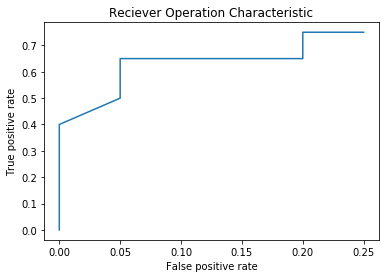

In [11]:
import numpy as np

print(fpr)  
print(tpr)

for i in range(len(threshold) - 1):
    fpr[i] = fpr[i]/(len(threshold)-1)
    tpr[i] = tpr[i]/(len(threshold)-1)

print(fpr)  
print(tpr)
plt.plot(fpr, tpr)
plt.title("Reciever Operation Characteristic")
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')